# Разведочный анализ данных опроса разработчиков Stack Overflow за 2023 год.

In [70]:
import pandas as pd
import zipfile
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

# Первичный анализ данных

Загружаем датасет

In [71]:
url = 'https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip'
response = requests.get(url) #загрузка архива по ссылке
#открытие архива в памяти с помощью io.BytesIO(response.content)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('survey_results_public.csv') as csv_file:
        df_2023 = pd.read_csv(csv_file)

flag = True #понадобится при дальнейшем анализе, чтобы понимать редактировлся ли уже датасет

**Основные числовые переменные**

    - ResponseID - уникальный идентификатор респондента;
    - CompTotal - размер заработной платы;
    - WorkExp - количество лет профессионального опыта;
    - ConvertedCompYEarly - размер заработной платы после конвертации в единую валюту.



In [72]:
df_2023.describe()

,ResponseId,CompTotal,WorkExp,ConvertedCompYearly
count,89184.000000,4.822500e+04,43579.000000,4.801900e+04
mean,44592.500000,1.036807e+42,11.405126,1.031101e+05
std,25745.347541,2.276847e+44,9.051989,6.814188e+05
min,1.000000,0.000000e+00,0.000000,1.000000e+00
25%,22296.750000,6.300000e+04,5.000000,4.390700e+04
50%,44592.500000,1.150000e+05,9.000000,7.496300e+04
75%,66888.250000,2.300000e+05,16.000000,1.216410e+05
max,89184.000000,5.000000e+46,50.000000,7.435143e+07


В данной таблице присутсвуют следующие обозначения:

    - count - количество непустых значений в столбце (доступные данные для анализа)
    - mean - среднее значение всех числовых значений в столбце, центраьная тенденция данных
    - std - стандартное отклонение, разброс данных относительно среднего значения
    - min - минимальное значение в столбце
    - 25% - первый квартиль, значение, которое выше 25% всех значений в столбце
    - 50% - второй квартиль, медиана, значение, которое выше 50% всех значений в столбце
    - 75% - третий квартиль, значение, которое выше 75% всех значений в столбце
    - max - максимальное значение в столбце

По этим данным можно сказать, что в столбце CompTotal скорее всего присутствуют выбросы, т.к. среднее значение и максимальные значения здесь слишком большие и сильно отличаются от квартилей

Преобразуем в более читабельный вид

In [73]:
print(df_2023.describe().to_string(float_format='%.2f'))

       ResponseId                                          CompTotal  WorkExp  ConvertedCompYearly
count    89184.00                                           48225.00 43579.00             48019.00
mean     44592.50     1036806635562467391394372602402550216392704.00    11.41            103110.08
std      25745.35   227684720124324374955124620267587368424308736.00     9.05            681418.84
min          1.00                                               0.00     0.00                 1.00
25%      22296.75                                           63000.00     5.00             43907.00
50%      44592.50                                          115000.00     9.00             74963.00
75%      66888.25                                          230000.00    16.00            121641.00
max      89184.00 49999999999999992051087350427974655758076739584.00    50.00          74351432.00


  1. Разницу между средним значением и медианой размера заработной платы в колонке `ConvertedCompYEarly` и в колонке `CompTotal` можно объяснить различным способом нахождения этих величин - если среднее мы ищем как сумму всех числовых значений и делим её на количество этих значений, то медиана - это значение, находящееся по середине в отсортированном столбце.

  2. А также среднее значение может отличаться от медианного ещё и по причине нахождения выбросов в данных.

  3. В некоторых переменных встречается одинаковое количество пропущенных значений из-за того, что пользователи могли систематически пропускать ответы на несколько вопросов сразу, а также пропущенные значения могут быть связаны с логической зависимостью между переменными. Например, если отсутствует ответ о зарплате, то также могут быть пропущены значения и о типе компании.

  4. Методы для заполнения пропущенных значений в данны:
  
* Заполнение средним, медианой или модой подходит для числовых данных при нормальном распределении:
 - df.fillna(df['столбец'].mean(), inplace=True)
 - df.fillna(df['столбец'].median(), inplace=True)
 - df.fillna(df['столбец'].mode()[0], inplace=True)

* Заполнение константой, если есть логическая причина заполнить пропуски определенным значением:
 - df.fillna(-1, inplace=True) #заполнить пропуски -1

* Удаление строк, если пропусков немного, и они не нарушают общую картину:
 - df.dropna(inplace=True)

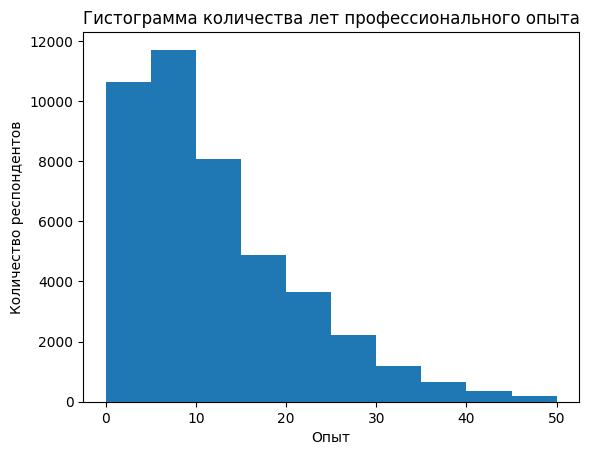

In [74]:
plt.hist(df_2023['WorkExp'], bins=10)

plt.title('Гистограмма количества лет профессионального опыта')
plt.xlabel('Опыт')
plt.ylabel('Количество респондентов')

plt.show()

**Выводы**

Всего респоднетов было 89 184. Однако на вопросы про размер заработной платы и проффесиональных опыт ответило около половины, откуда следует, что в датасете достаточно много пропущенных значений.

В датасете присутсвуют выбросы, это можно заметить в столбце размера заработной платы, где среднее и максимальное значения слишком большие цифры, однако медиана и третий квартиль - нет, а также минимальные значения очень маленькие, по сравнению с первым квартилем (это присутствует и в столбце размера заработной платы и в размере заработной платы после конвертации в единую валюту), откуда и следуют предположения о выбросах в этом столбце.

На гистограмме количества лет проффесионального опыта можно увидеть, что у большинства респондентов он не достигает 20 лет, но в целом распределён достаточно равномерно.

# Визуализация пропущенных значений

Столбцы с минимальным значением пропусков

In [75]:
df_2023.isnull().sum().sort_values().head(10)

,0
ResponseId,0
Q120,0
MainBranch,0
Age,0
EdLevel,1211
AISelect,1211
NEWSOSites,1211
Country,1211
Employment,1286
SOAccount,1332


Столбцы с максимальным значением пропусков

In [76]:
df_2023.isnull().sum().sort_values().tail(10)

,0
AIToolCurrently Using,53047
AIToolInterested in Using,56401
AIDevHaveWorkedWith,63280
AINextSomewhat different,65881
AIToolNot interested in Using,68115
AIDevWantToWorkWith,69597
AINextVery different,76523
AINextNeither different nor similar,82585
AINextSomewhat similar,82946
AINextVery similar,86563


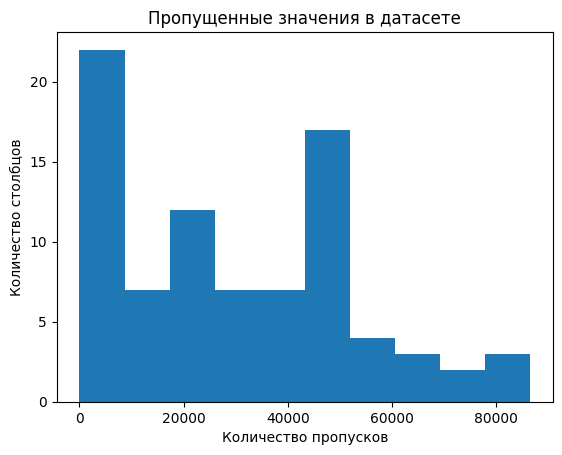

In [77]:
plt.hist(df_2023.isnull().sum())

plt.title('Пропущенные значения в датасете')
plt.xlabel('Количество пропусков')
plt.ylabel('Количество столбцов')

plt.show()

На этом графике видно, что почти половина столбцов имеют пропуски в 40 000 и выше значений

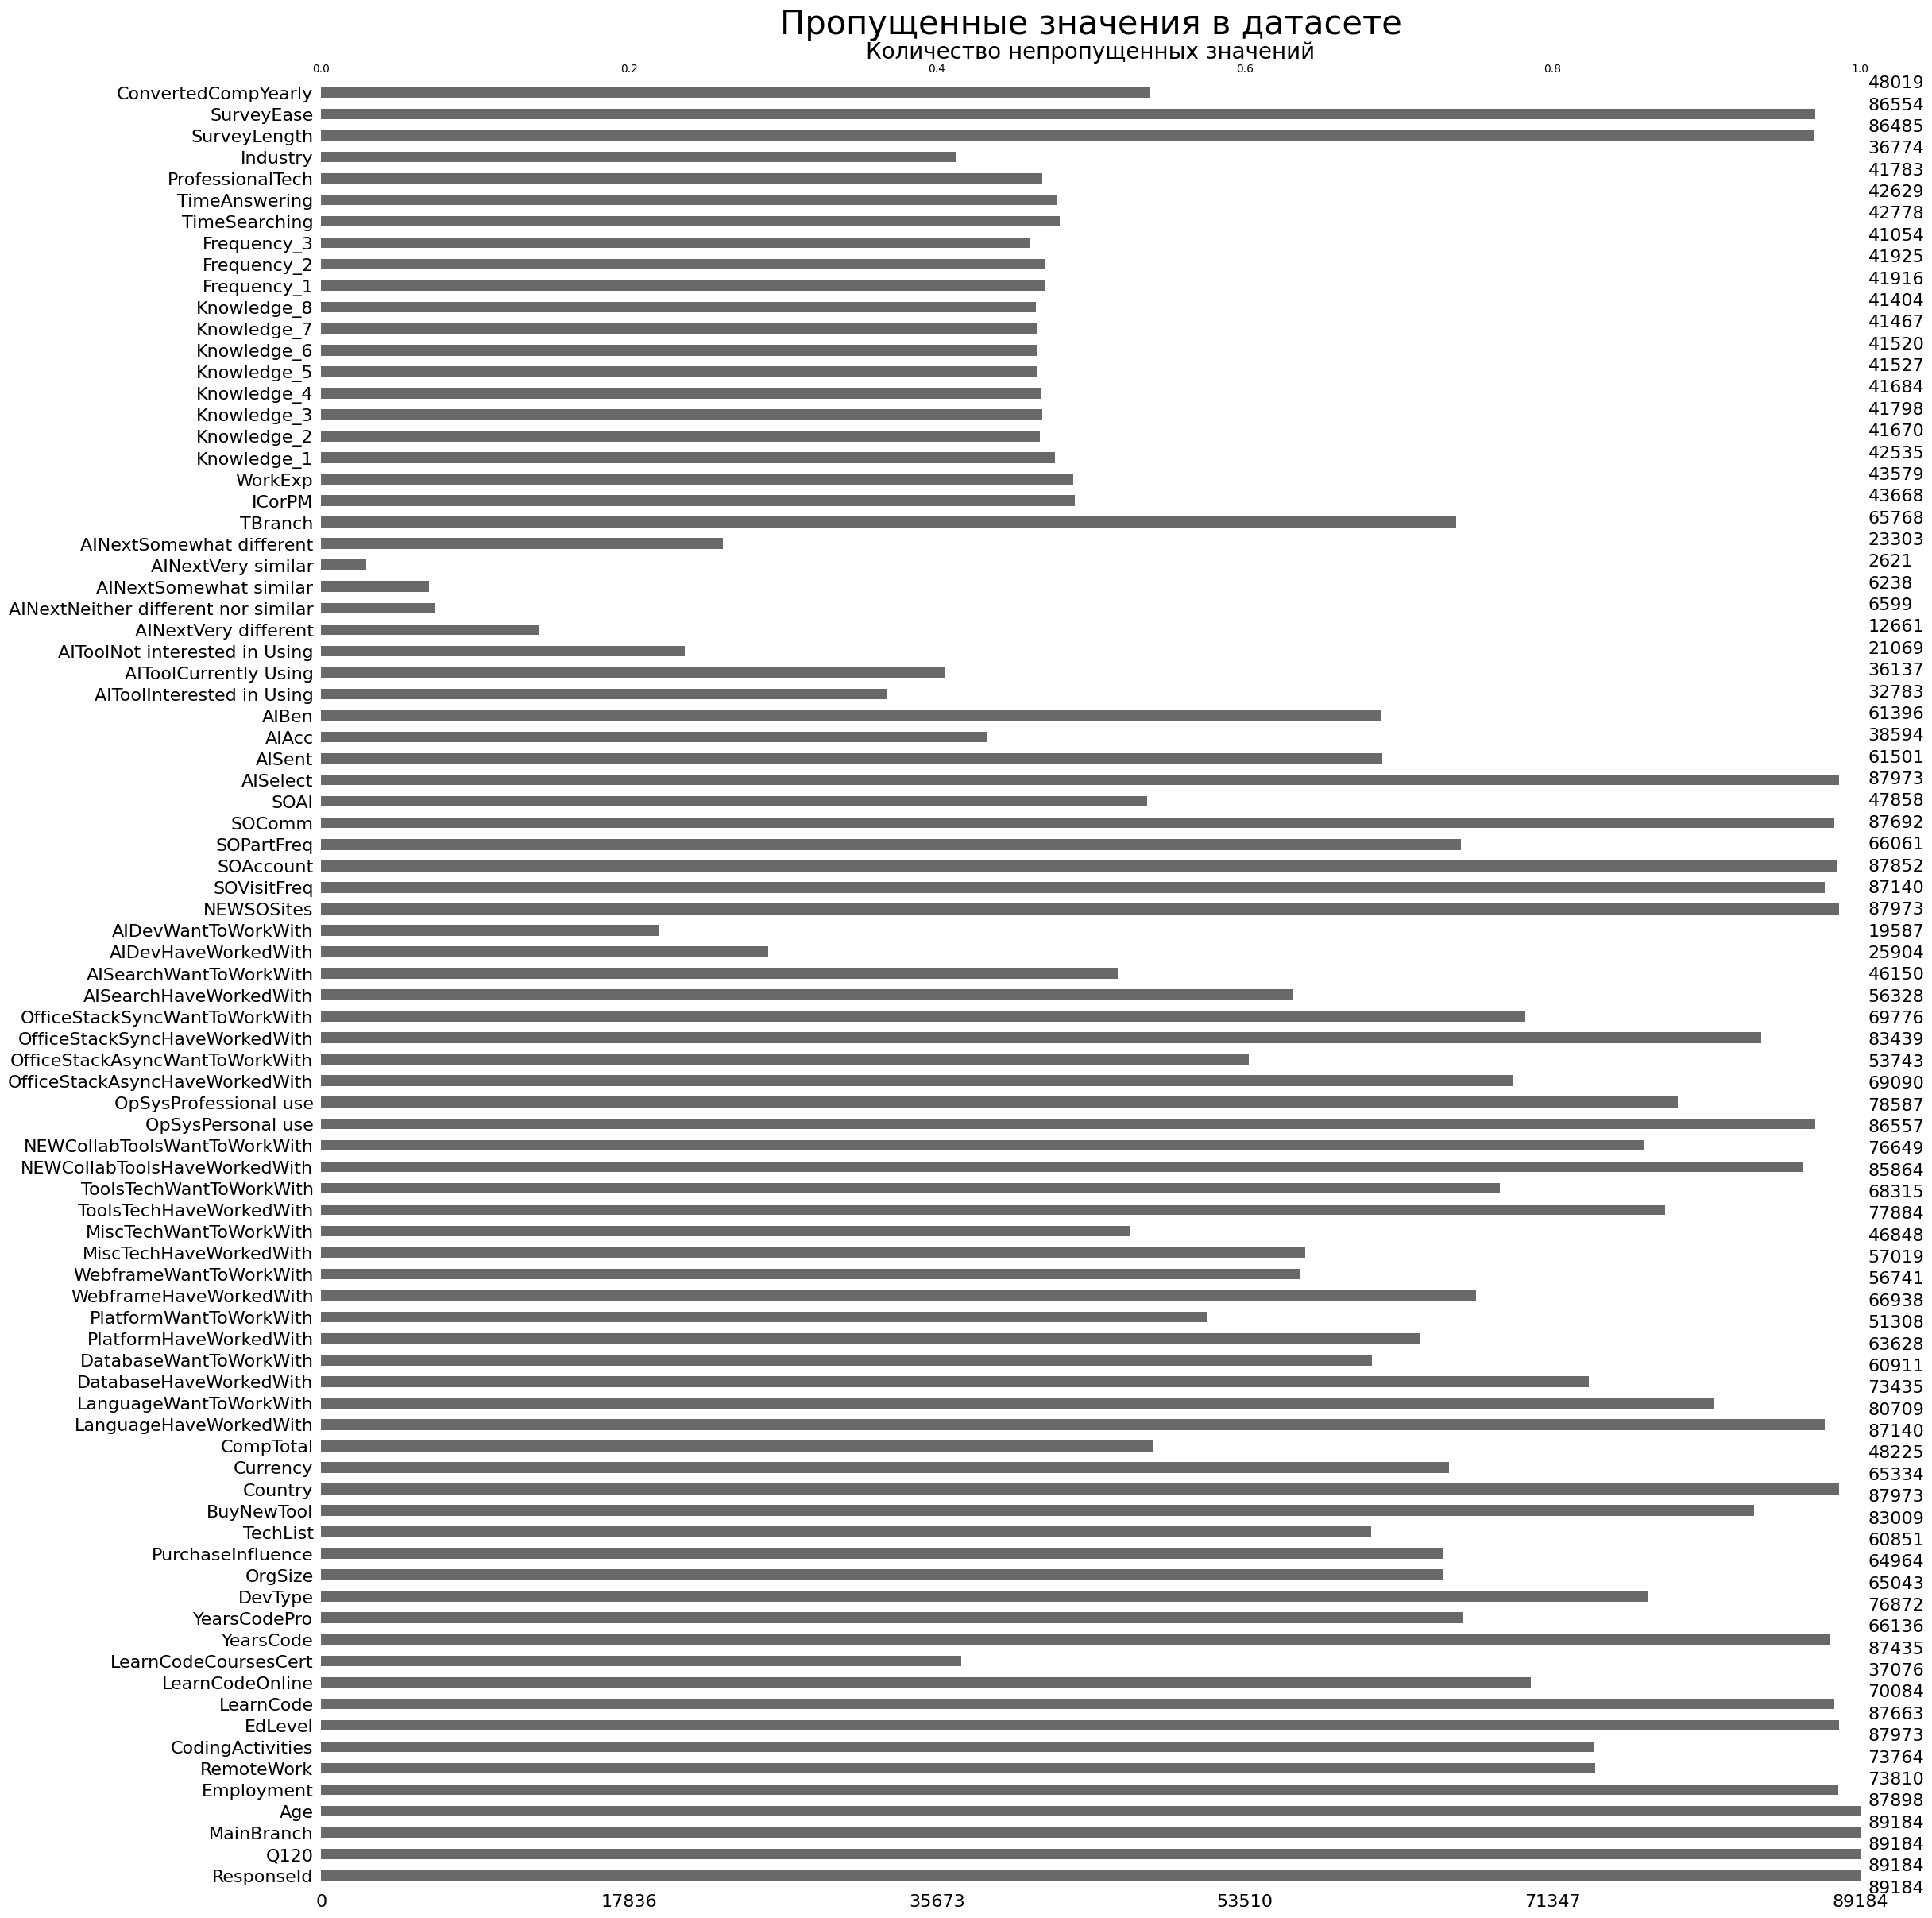

In [78]:
msno.bar(df_2023)
plt.title('Пропущенные значения в датасете', fontsize=30)
plt.xlabel('Количество непропущенных значений', fontsize=20)
plt.show()

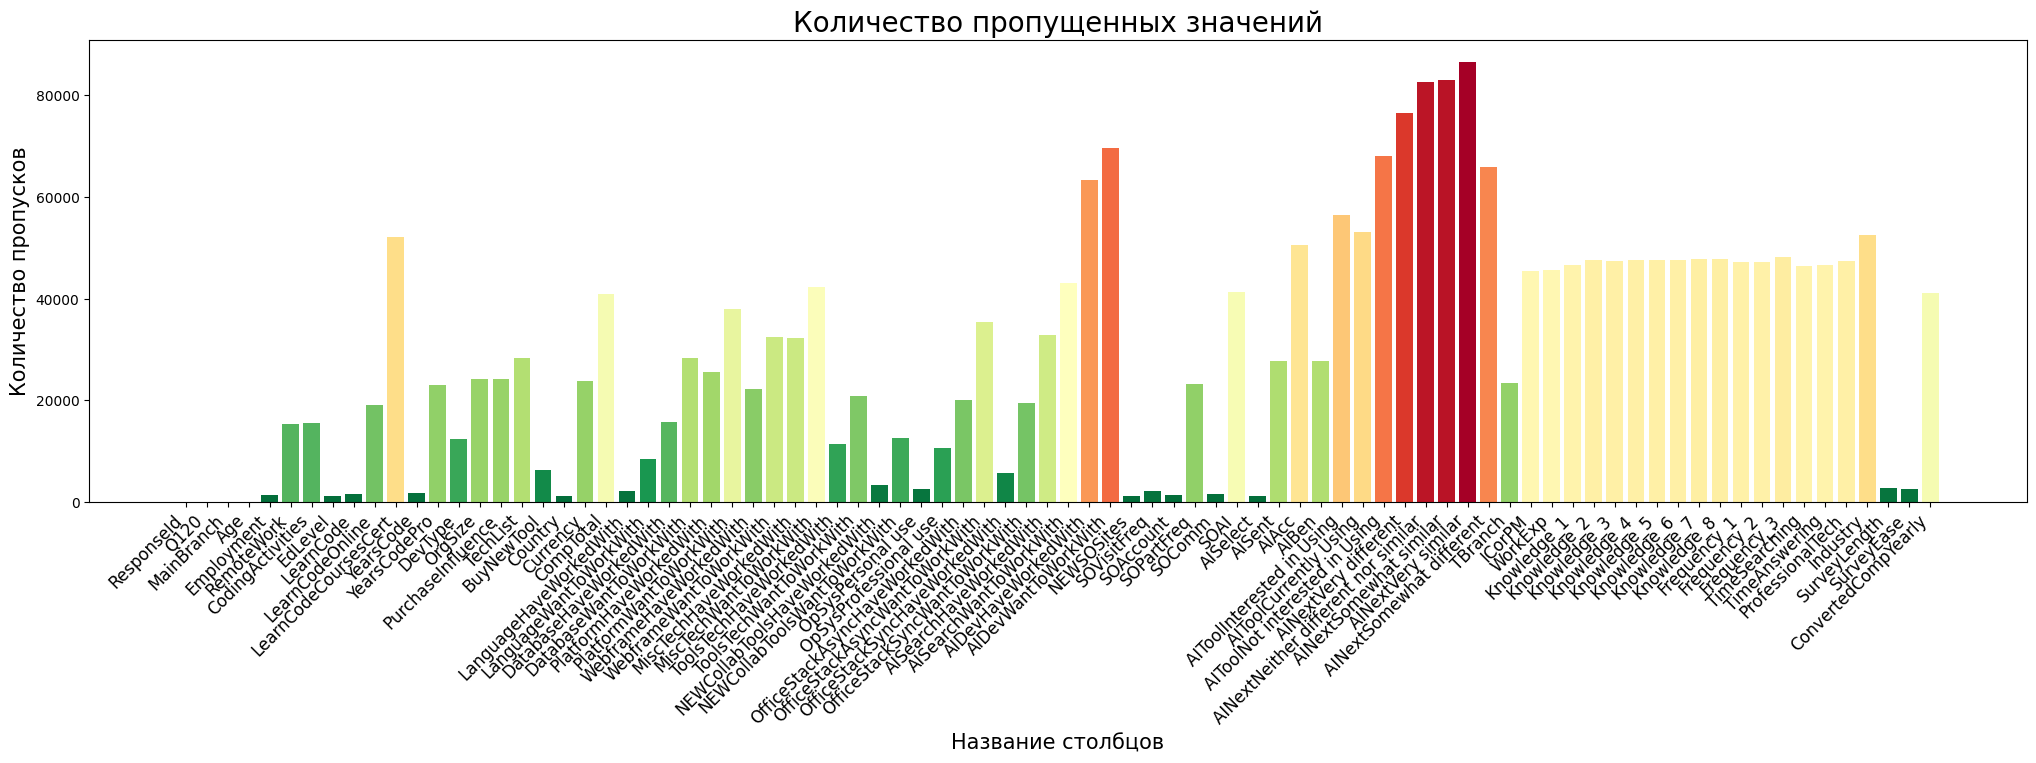

In [79]:
missing_counts = df_2023.isnull().sum()

colors = []
for count in missing_counts:
    #чем больше пропусков, тем краснее
    color = plt.cm.RdYlGn(1 - (count / missing_counts.max()))
    colors.append(color)

plt.figure(figsize=(25, 6))
plt.bar(missing_counts.index, missing_counts.values, color=colors)

plt.title("Количество пропущенных значений", fontsize=20)
plt.xlabel('Название столбцов', fontsize=15)
plt.ylabel('Количество пропусков', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)

plt.show()

На основе этих графиков можно увидеть, что, действительно, почти у половины столбцов пропущенные значения достигают отметки в 40 000 и выше.

**Вывод**

Столбцами без пропусков являются: ResponseID, Q120, MainBranch (основная сфера деятельности), Age.

Столбцы, которые больше всего подвержены пропускам: AINextVery similar, AINextSomewhat similar, AINextNeither different nor similar и AINextVery different. Эти столбцы относятся к секции “AI and Machine Learning” в анкете и отражают отношение разработчиков к искусственному интеллекту и машинному обучению. AINextVery similar отражает мнение разработчика о том, что ИИ и МО очень сильно изменят его работу, AINextSomewhat similar - ИИ и МО довольно сильно изменят его работу, AINextNeither different nor similar - ИИ и МО не сильно изменят его работу, или не уверен в этом, AINextVery different - ИИ и МО не сильно изменят его работу.

В этих столбцах пропуски достигают отметки 80 000, что говорит нам о том, что почти ни один респондент не оставил ответа. Из-за этого при дальнейшем анализе данных в секции “AI and Machine Learning” могут быть сделаны неправильные выводы, опирающиеся на малое число людей, т.е. на искаженные данные. Мы не сможем получить полную картину отношения разработчиков к ИИ и получить случайные выборки - они могут быть неслучайными, например, разработчики, отвечающие на вопросы об ИИ, были более заинтересованы в этой теме, чем те, кто пропустил эти вопросы.

Чтобы анализ был полный, можно заполнить пропуски медианой или средним, это сохранит структуру и размеры датасета, однако может оставить искажение данных. Ещё один способ - игнорирование пустых значений, но это приведет к неполному анализу и всё также останется высокая вероятность смещенной выборки. Способ удаления не стоит даже рассматривать, т.к. тогда у нас из всех респондентов останется всего около 3%.

# Анализ способов изучения программирования

Поймём какие существуют значения в столбце *LearnCode*

In [80]:
def get_unique_values(df, column_name):
  unique_values = set()
  for value in df[column_name]:
    #преобразуем значение в строку, если оно не строка
    if not isinstance(value, str):
      value = str(value)
    for item in value.split(';'):
      unique_values.add(item.strip())
  return unique_values

get_unique_values(df_2023, 'LearnCode')

{'Books / Physical media',
 'Coding Bootcamp',
 'Colleague',
 'Friend or family member',
 'Hackathons (virtual or in-person)',
 'On the job training',
 'Online Courses or Certification',
 'Other (please specify):',
 'Other online resources (e.g., videos, blogs, forum)',
 'School (i.e., University, College, etc)',
 'nan'}

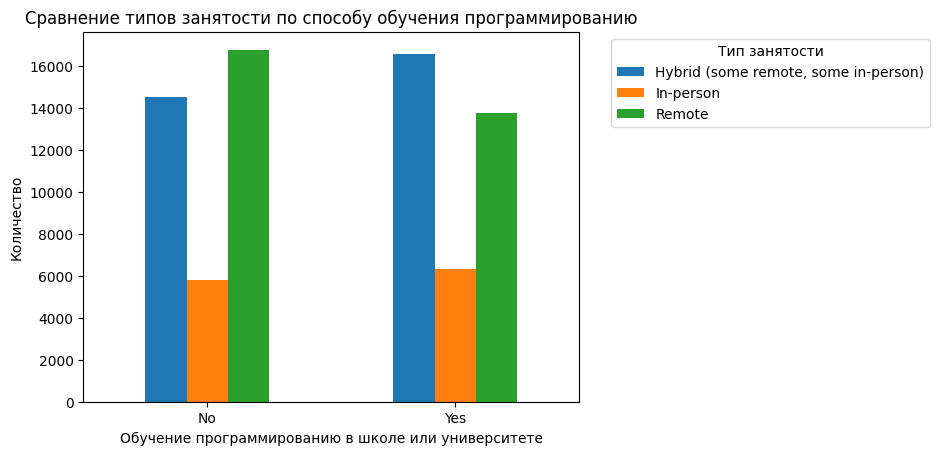

In [81]:
def process_learn_code(df):
  df['LearnCode'] = df['LearnCode'].fillna('').astype(str)  # Замена пустых значений на пустые строки
  df['LearnCodeInSchool'] = df['LearnCode'].apply(lambda x: 'Yes' if any(
      'School (i.e., University, College, etc)' in item for item in x.split(';')
  ) else 'No')
  return df

df = process_learn_code(df_2023)
#unstack() преобразует результат подсчета в табличный вид
df.groupby('LearnCodeInSchool')['RemoteWork'].value_counts().unstack().plot(kind='bar', rot=0)
plt.title("Сравнение типов занятости по способу обучения программированию")
plt.xlabel("Обучение программированию в школе или университете")
plt.ylabel("Количество")
#переместим легенду за пределы графика
#bbox_to_anchor=(1.05, 1) - позиция легенды относительно нижнего левого угла графика.
#1.05 - легенда будет смещена на 5% вправо от правой границы графика.
#1 - легенда будет смещена вверх на 100% от нижней границы графика.
#loc='upper left' - выравнивание легенды по верхнему левому углу.
plt.legend(title="Тип занятости", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

От того, где человек обучался программированию не сильно зависит его тип занятости. Так, на столбчатой диаграмме мы можем увидеть, что очная форма (In-person) достигает отметки всего в 6 000 вне зависимости от места обучения. А гибрид и удалённая формы имеют значения выше 14 000 с разницой между друг другом около 2 000. Однако у тех, кто учился программированию в школе или университете преобладает гибридный тип занятости, у остальных - удалённый.

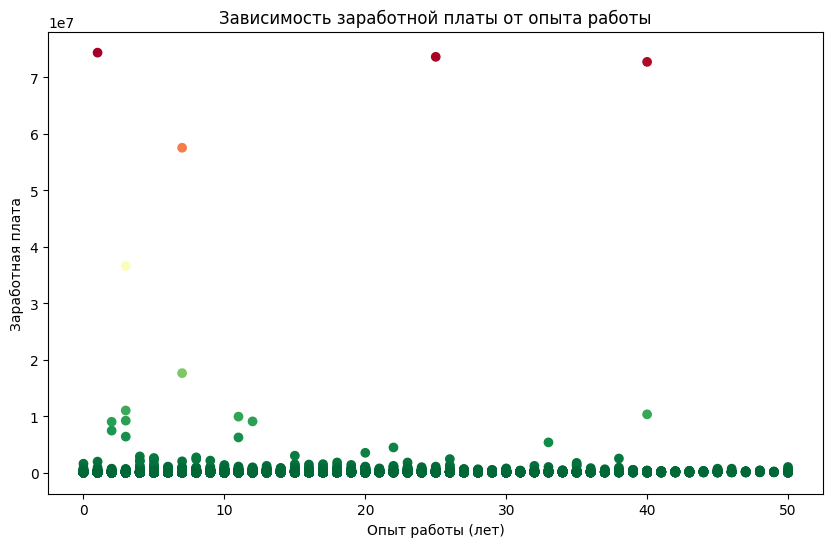

In [82]:
#оставляем только цифры. regex=True - используется регулярное выражение
#но делаем это только один раз!! поэтому используем flag
if flag:
  df['YearsCodePro'] = df['YearsCodePro'].str.replace(r'[^0-9]', '', regex=True)
  flag = False

#преобразуем строковые данные в числовые
df['YearsCodePro'] = df['YearsCodePro'].replace("Less than 1 year", 0.5)
df['YearsCodePro'] = df['YearsCodePro'].replace("More than 50 years", 55)

#pd.to_numeric() - преобразование строки в числа типа float
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro']).fillna(0)

plt.figure(figsize=(10, 6))

#нормализация значений зарплаты в диапазоне от 0 до 1
normalized_salary = (df['ConvertedCompYearly'] - df['ConvertedCompYearly'].min()) / (
    df['ConvertedCompYearly'].max() - df['ConvertedCompYearly'].min()
)
#цветовая карта градиента от красного до зелёного
colors = plt.cm.RdYlGn(1 - normalized_salary)

plt.scatter(df['YearsCodePro'], df['ConvertedCompYearly'], c=colors)
plt.title("Зависимость заработной платы от опыта работы")
plt.xlabel("Опыт работы (лет)")
plt.ylabel("Заработная плата")
plt.show()

На этом графике мы видим, что в целом зарплата распределяется равномерно в течении всего опыта работы. Также можно сказать, что в датасете присутствует небольшое количество выбросов в виде слишком высоких значений. Выведем график без них



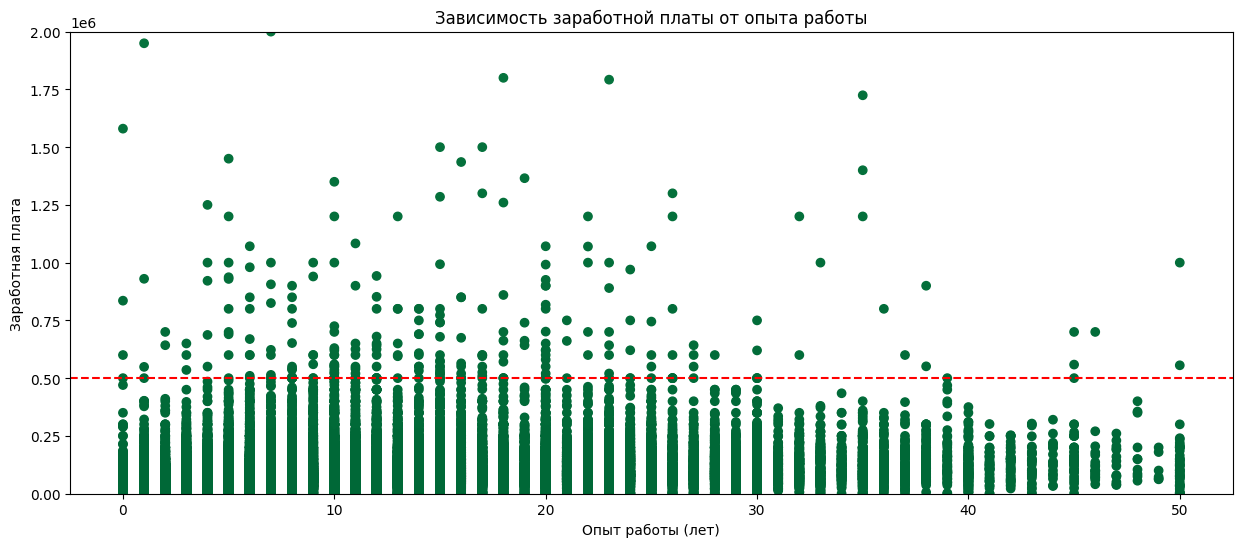

In [83]:
plt.figure(figsize=(15, 6))
plt.scatter(df['YearsCodePro'], df['ConvertedCompYearly'], c=colors)
plt.ylim(0, 2_000_000)
plt.title("Зависимость заработной платы от опыта работы")
plt.xlabel("Опыт работы (лет)")
plt.ylabel("Заработная плата")
plt.axhline(y=0.501e6, color='red', linestyle='--')
plt.show()

На данном графике можно точнее рассмотреть возможную зависимость между зараплатой и опытом работы. Видно, что идёт некий рост заработной платы к 12 годам опыта и к 20. Однако в последствии, чем дальше, тем заработная плата в своём большинстве уменьшается. Также, в целом можно заметить тенденцию зарплат в районе отметки 500 000. Выше этого числа достаточно редко доходят значения.

In [84]:
correlation = df['YearsCodePro'].corr(df['ConvertedCompYearly'])
print(f"\nКоэффициент корреляции: {correlation}")


Коэффициент корреляции: 0.04170249721695795


Коэффициент корреляции между опытом работы и размером заработной платы, равен 0.0417, получается между этими двумя переменными существует очень слабая положительная корреляция, т.к значение ближе к 0, чем к 1. Получается увеличение опыта работы не приводит к значительному увеличению зарплаты.

# Анализ уровня образования и заработной платы в разных странах

Предварительная сортировка

In [85]:
#сртируем страны по количеству респондентов и берем топ-10
top_10_countries = df['Country'].value_counts().nlargest(10).index
#фильтруем DataFrame, оставляя только данные по топ-10 странам
df_top_10 = df[df['Country'].isin(top_10_countries)]

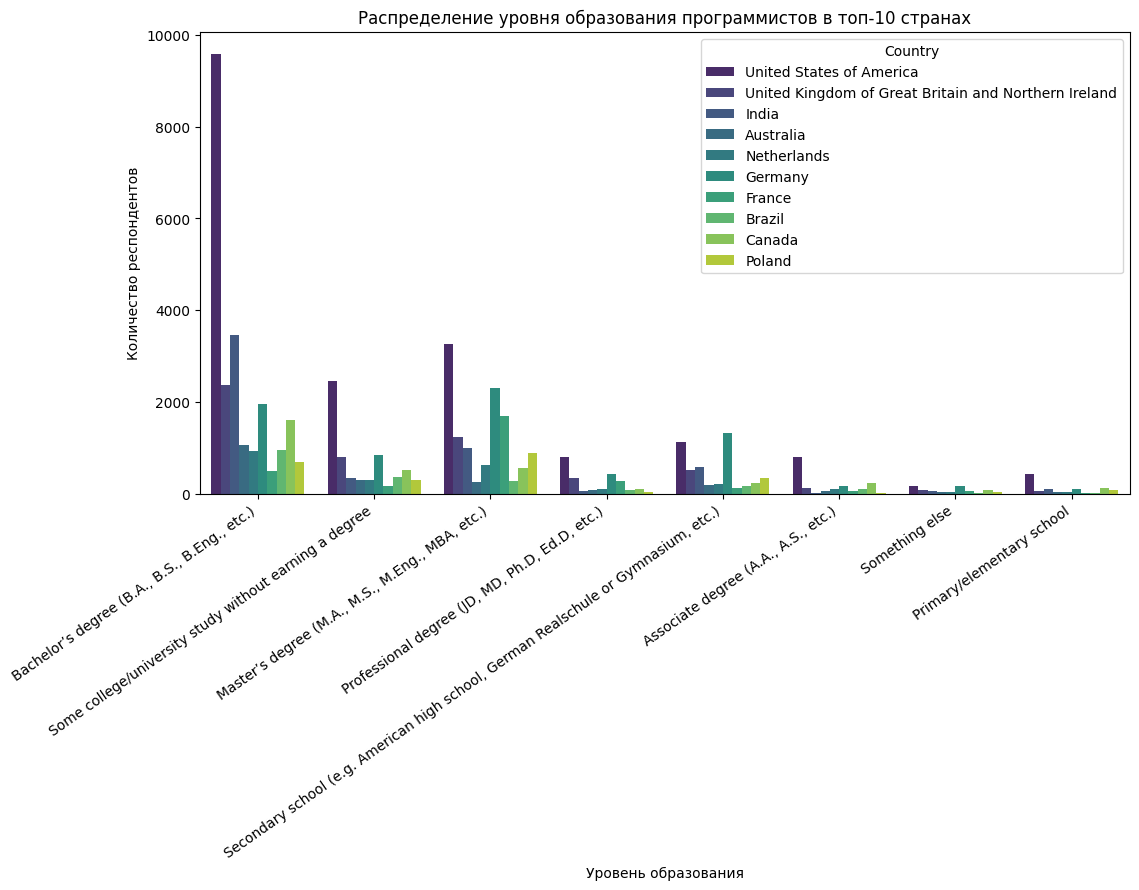

In [86]:
plt.figure(figsize=(12, 6))
sns.countplot(x='EdLevel', hue='Country', data=df_top_10, palette='viridis')
plt.title('Распределение уровня образования программистов в топ-10 странах')
plt.xlabel('Уровень образования')
plt.ylabel('Количество респондентов')
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.show()

На графике распределения уровня образования программистов в топ-10 странах явно видно, что респонденты преимущественно имеют степень бакалавра или магистра. Причём бакалавров больше всего в США, Индии и Великобритании, а магистров - в США, Германии и Франции. Отсюда можно сделать вывод, что в США являются довольно популярными высшие учебные заведения для программистов. А в Европе люди охотнее идут в магистратуру, чем в других странах.

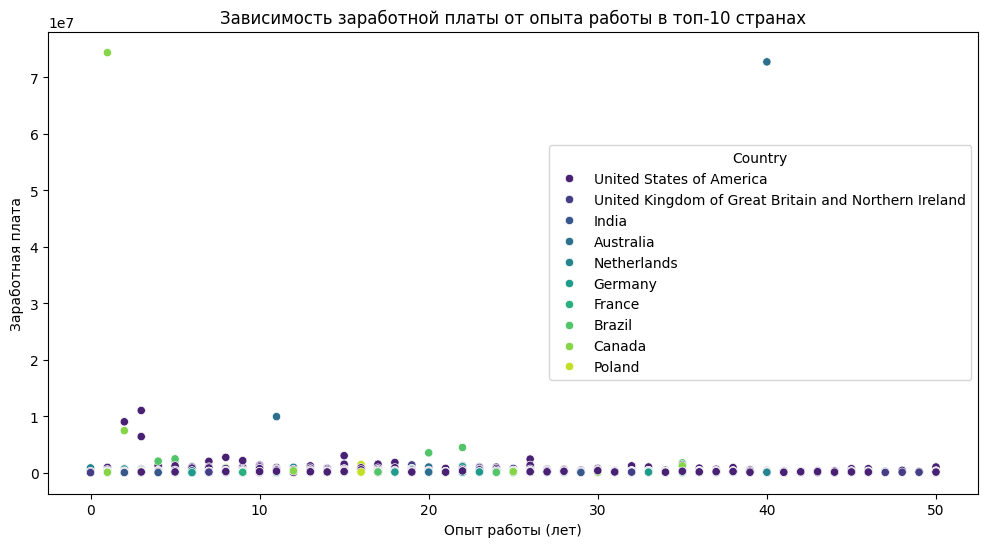

In [87]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='YearsCodePro', y='ConvertedCompYearly', hue='Country', data=df_top_10, palette='viridis')
plt.title('Зависимость заработной платы от опыта работы в топ-10 странах')
plt.xlabel('Опыт работы (лет)')
plt.ylabel('Заработная плата')
plt.show()

На этом графике мы также можем увидеть очень равномерное распределение зарплат, однако и тут присутсвуют выбросы. Для дальнейшего анализа преобразуем график

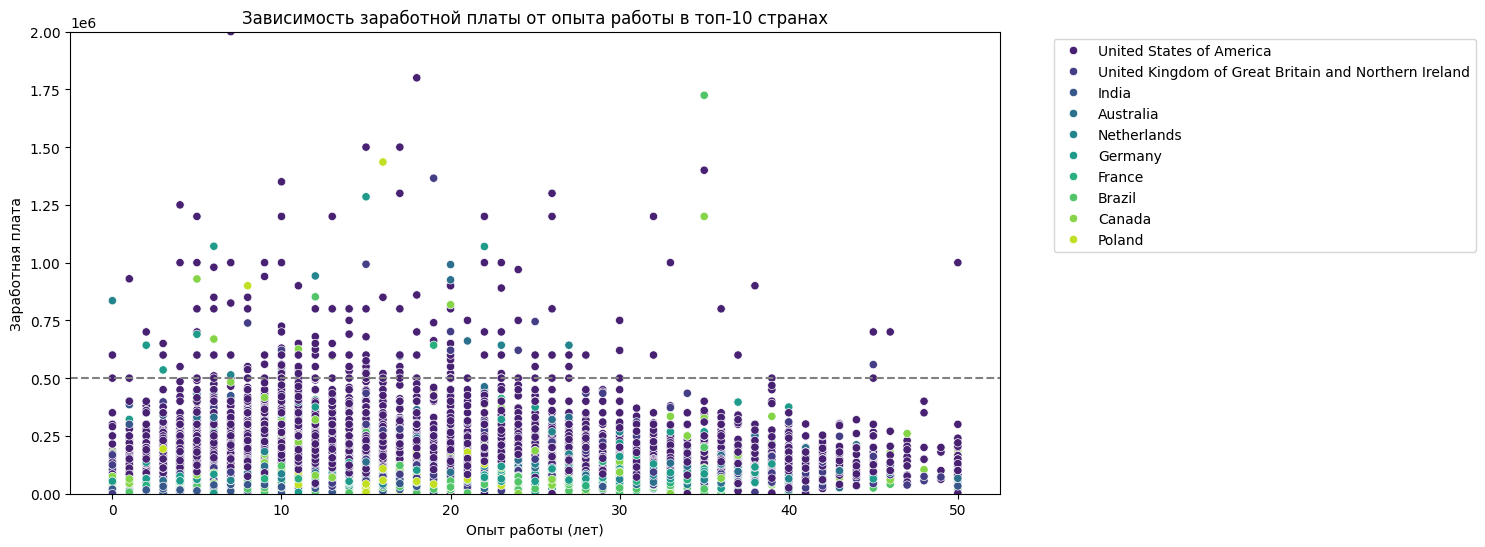

In [88]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='YearsCodePro', y='ConvertedCompYearly', hue='Country', data=df_top_10, palette='viridis')
plt.ylim(0, 2_000_000)
plt.title('Зависимость заработной платы от опыта работы в топ-10 странах')
plt.xlabel('Опыт работы (лет)')
plt.ylabel('Заработная плата')
#переместим легенду за пределы графика
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=0.501e6, color='gray', linestyle='--')
plt.show()

На этом графике заметно, что самые высокие зарплаты зачастую встречаются в США, что можно объяснить популярностью и востребованностью высшего образования, а самые низкие чаще всего в Бразилии и Франции. Также заметна тенденция, что с увеличением опыта работы после 30 лет заработная плата сильно падает по всем странам. Но здесь можно заметить, что максимальный опыт работы (50 лет) наблюдается только лишь в Великобритании и США.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


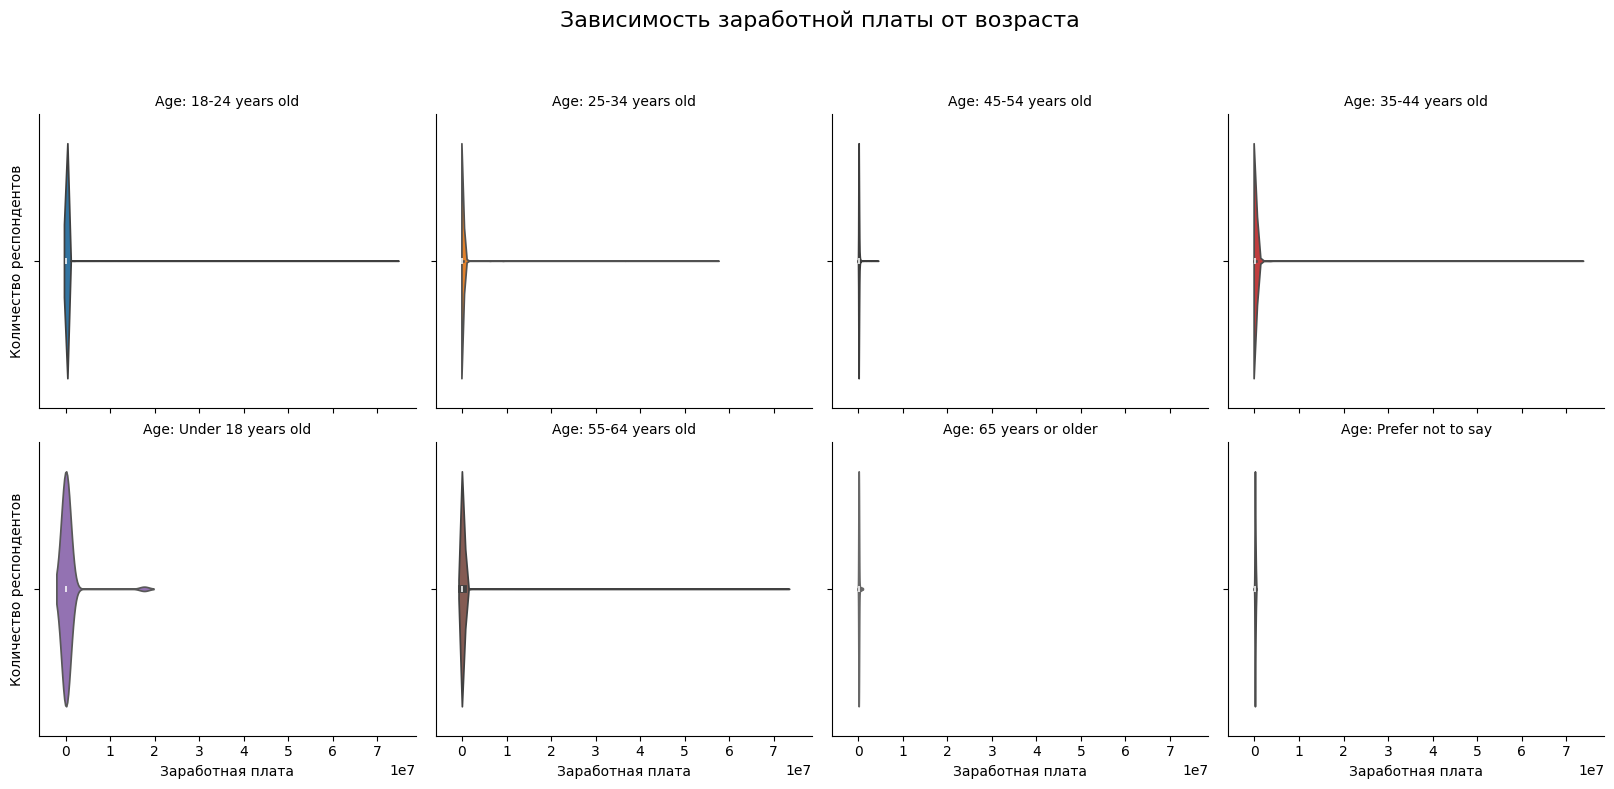

In [89]:
#создаем объект FacetGrid для построения графиков по возрастным группам
g = sns.FacetGrid(df_2023, col='Age', hue='Age', col_wrap=4, height=4)
g.map(sns.violinplot, 'ConvertedCompYearly')
g.fig.suptitle('Зависимость заработной платы от возраста', fontsize=16)
g.set_titles(col_template='Age: {col_name}')
g.set_axis_labels('Заработная плата', 'Количество респондентов')
#смещаем графики вниз
g.fig.subplots_adjust(top=0.85)  #top - верхний край графика
plt.show();

По этому графику видно, что возрастная группа до 18 лет иммет больше всех разброс по заработной плате.

Возрастные группы 18-24, 25-34, 35-44 и 55-64 имеют чуть меньший разброс, однако тут видны длинные "хвосты", сигнализирующие нам о выбросах в значениях этих групп.

У групп 45-54, 25+ и с неуказанным возрастом наблюдается чрезвычайно маленький разброс значений.

Рассмотрим графики немного "поближе"

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


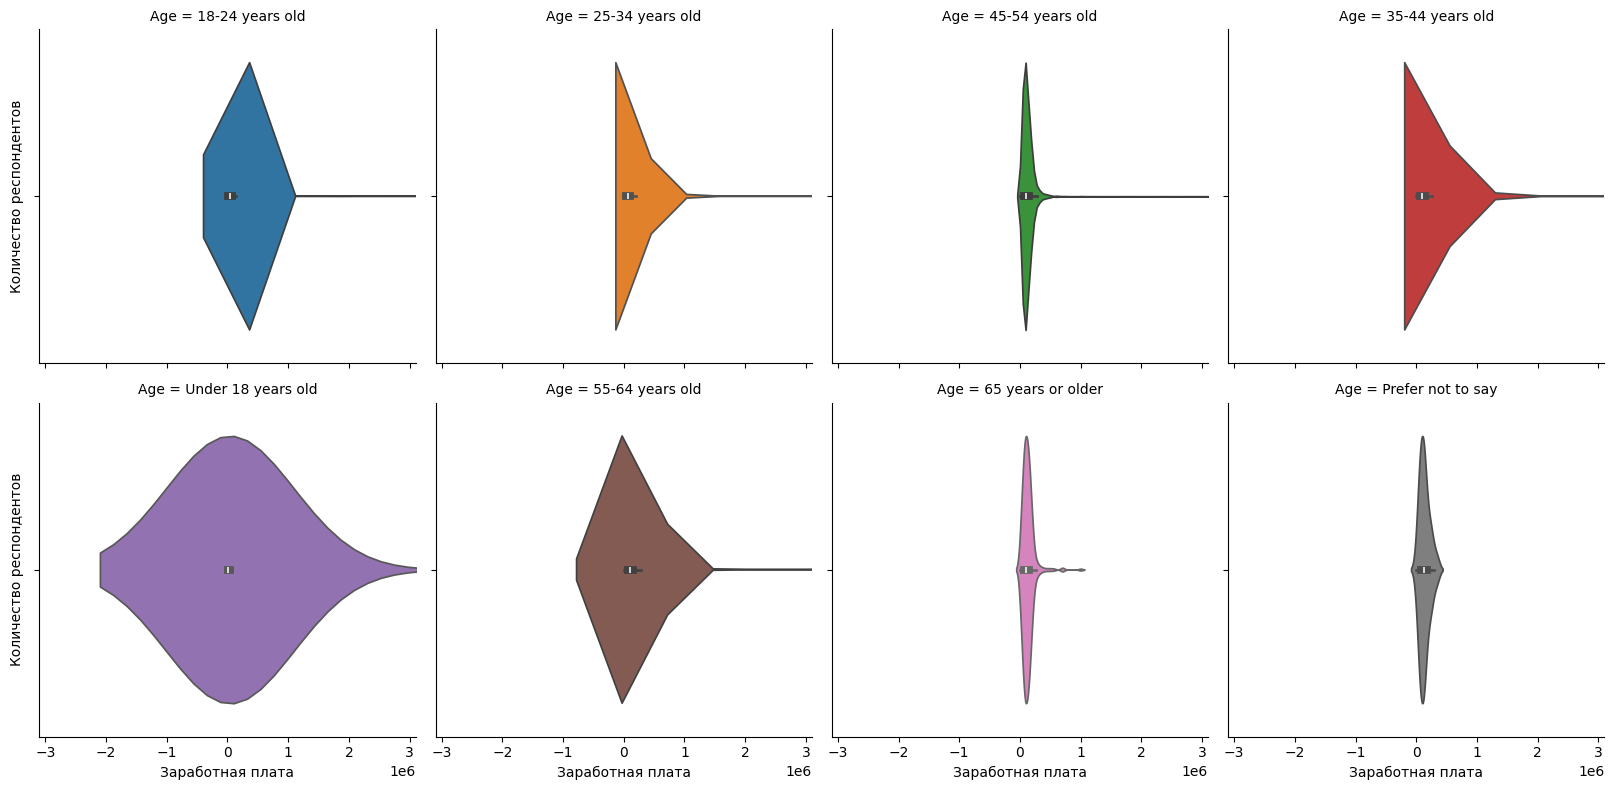

In [90]:
g = sns.FacetGrid(df_2023, col='Age', hue='Age', col_wrap=4, height=4)
g.map(sns.violinplot, 'ConvertedCompYearly')
g.set_axis_labels('Заработная плата', 'Количество респондентов')
g.set(xlim=(-0.31e7, 0.31e7))
plt.show();

Здесь мы можем детальнее рассмотреть график. Пройдёмся по тем же возрастным группам.

Возрастная группа до 18 лет имеет много значений ниже 0, что является выбросами. Самые популярные значения в данном категории находятся в диапазоне между 0 и 1 000 000. Маскимальные значения переходят границу в 3 000 000. Это говорит нам о том, что скорее всего с развитием новых техгологий порог входа в данную сферу сильно снизился и люди младше 18 лет также могут получать высокую зарплату.

Возрастные группы 18-24 и 55-64 имеют схожую структуру данных. Однако в первом случае значений меньших и равных 0 очень мало, здесь самым популярным значениям является отметка около 500 000, а максимум доходит до чуть больше, чем 1 000 000. Во втором же случае мы видим намного больше отрицательных значений, а самыми популярными являются те, что рядом с 0. Однако здесь максимум доходит почти до 1 500 000. Это наблюдение опкзаывает нам, что люди до 24 лет в своём большинстве зарабатывают больше, чем люди 55-64 лет, однако максимальное значение зарабатной платы принадлежит возрастной группе 55-64

В группах 25-34 и 35-44 наблюдается тенденция, что больше всего значений равных 0 и ниже, а далее идёт плавное уменьшее, которое доходит до значений 1 000 000 и 2 000 000 соответсвенно.

У групп 45-54, 25+ и с неуказанным возрастом нет отрицательных значений, однако диапазон стабильно находится в промежутке от 0 до 500 000. Можно предположить, что для этих возрастных групп программирование не является основным видом дейтельности.

В целом, можно сделать следующие выводы. Макимальная заработная плата принадлежит возрастной группе до 18 лет, однако в ней же и подозрение на большое количесвто выбросов. После неё идут группы 55-64 и 35-44. Если брать самое высокое значение заработной платы по большинство респондентов возрастных группах, то лидером будет 18-24.

# Анализ изменения уровня заработной платы после пандемии

Загружаем необходимые для анализа датасеты

In [91]:
def load_datasets(urls, names):
  for i, url in enumerate(urls):
    response = requests.get(url) #загружаем архив по ссылке
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
      with z.open('survey_results_public.csv') as csv_file:
        #создаем датафрейм с именем из df_names
        globals()[names[i]] = pd.read_csv(csv_file)

urls = [
    'https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip',
    'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip',
    'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2021.zip',
    'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip',
    'https://survey.stackoverflow.co/datasets/stack-overflow-developer-survey-2019.zip'
]

df_names = ['df_2023', 'df_2022', 'df_2021', 'df_2020', 'df_2019']
datasets = load_datasets(urls, df_names)

Также для дополнительной автоматизации можно задавать имена датафреймов с помощью range(2019, 2024), так же поступить и со схожими ссылками за 2020-2022 года

In [92]:
countries = ['United States of America', 'United Kingdom of Great Britain and Northen Ireland', 'India', 'Australia', 'Netherlands']
years = range(2019, 2024)

#медианные зарплаты для каждой страны и года
median_salaries = []
#перебор всех комбинаций годов, стран и датафреймов
for year in years:
    for country in countries:
        for df_name in df_names:
            df = globals()[df_name]
            if year == int(df_name[-4:]):  #проверяем год датафрейма
                median_salary = df[df['Country'] == country]['ConvertedCompYearly'].median()
                median_salaries.append({'Year': year, 'Country': country, 'MedianSalary': median_salary})

#создаем датафрейм из полученных данных
median_salary_df = pd.DataFrame(median_salaries)

KeyError: 'ConvertedCompYearly'

Поймём где ошибка. Скорее всего столбцы в 2019 году назывались по-другому

In [93]:
df_2019 = globals()['df_2019']  #получить значение глобальной переменной
df_2019.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


Да, ошибка состояла в том, что в 2019 год столбец ConvertedCompYearly назывался ConvertedComp.

In [94]:
countries = ['Canada', 'Australia', 'Netherlands', 'Germany', 'France']
years = range(2019, 2024)

median_salaries = []
for year in years:
    for country in countries:
        for df_name in df_names:
            df = globals()[df_name]
            if year == int(df_name[-4:]):
                try:
                    median_salary = df[df['Country'] == country]['ConvertedCompYearly'].median()
                    median_salaries.append({'Year': year, 'Country': country, 'MedianSalary': median_salary})
                except KeyError:
                    median_salary = df[df['Country'] == country]['ConvertedComp'].median()
                    median_salaries.append({'Year': year, 'Country': country, 'MedianSalary': median_salary})

median_salary_df = pd.DataFrame(median_salaries)
median_salary_df

,Year,Country,MedianSalary
0,2019,Canada,68705.0
1,2019,Australia,79783.0
2,2019,Netherlands,57287.0
3,2019,Germany,63016.0
4,2019,France,46752.0
5,2020,Canada,93701.0
6,2020,Australia,93772.0
7,2020,Netherlands,66119.0
8,2020,Germany,69318.0
9,2020,France,51192.0


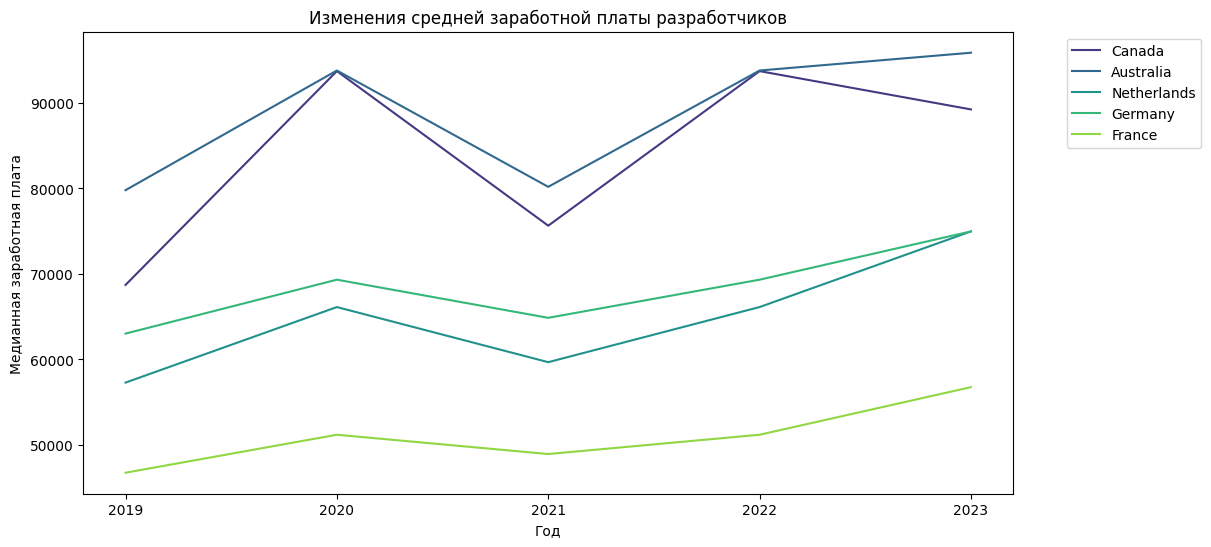

In [95]:
plt.figure(figsize=(12, 6))
median_salary_df['Year'] = median_salary_df['Year'].astype(str)
sns.lineplot(x='Year', y='MedianSalary', hue='Country', data=median_salary_df,
             palette='viridis')
plt.title('Изменения средней заработной платы разработчиков')
plt.xlabel('Год')
plt.ylabel('Медианная заработная плата')
#переместим легенду за пределы графика
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# устанавливаем метки оси X для каждого года
plt.xticks(median_salary_df['Year'].unique())

plt.show()

**Выводы**

В выбранных странах (Канада, Австралия, Нидерланды, Германия, Франция) в целом наблюдается тренд роста средних зарплат разработчиков с 2019 по 2023 год.

*Влияние пандемии COVID-19:*

Пандемия усилила тренд роста заработной платы в данной сфере:

- Увеличился спрос разработчиков, т.к. пандемия стимулировала рост онлайн-сервисов, e-commerce и цифровых решений, что привело к дифициту квалифицированных IT-специалистов, а в последствии к конкуренции за лучших разработчиков и росту зарплат.
- Также, во время пандемии был массовый переход на удаленную работу, что позволило компаниям расширить кадры даже за счет специалистов из других стран с более низкими зарплатами, что привело к "выравниванию" зарплат в разных странах.
- По графику также можем сказать, что в пандемийный год был резкий скачок в зарплатах, причиной этому можно найти в том, что во время пандемии многие люди стали погружаться в IT-сферу, менять работу и изучать программирование. Поэтому после был некий спад в зарплатах, т.к. рынок был перегружен специалистами. Сейчас же IT-сфера быстро развивается и дефицит сотрудников вновь даёт о себе знать и заставлять компании повышать зарплаты для привлечения высококвалифицированных специалистов.

Ещё одна важная причина повышения зарпалты - это инфляция: повышение стоимости жизни в некоторых странах привело к росту зарплат, чтобы сохранить покупательную способность работников.

Отдельно по странам:
- Канада: сильный рост зарплат может быть связан с быстрым развитием IT-индустрии
- Австралия: рост зарплат также может быть связан с развитием технологического сектора и в целом высоким уровенем жизни в стране
- Нидерланды: устойчивая экономика и меньший спрос на разработчиков по сравнению с другими странами спосбствуют умеренному росту зарплат
- Германия: здесь маленький рост зарпла может быть связан с "традиционным" подходом к компенсации работников и менее динамичной IT-индустрией
- Франция: незначительный рост зарплат может быть связан с сильными профсоюзами и государственным регулированием зарплат

В целом, пандемия COVID-19 оказала значительное влияние на уровень зарплат разработчиков в разных странах. Она ускорила рост спроса на IT-специалистов и стимулировала переход на удаленную работу, что привело к изменению условий рынка труда и конкуренции за квалифицированных специалистов.



# Интерпретация данных и формулирование гипотез

**Общие выводы**

1. *Место обуение и форма работы*

  От места обучения программированию не зависит будущий тип занятости человека. Очная форма в любом случае остаётся на одинаковом уровне у всех, а гибрид и удалённая формы имеют разницу между друг другом около 2 000 респондентов, считая между теми, кто окончил школу/университет и остальными.

2. *Опыт работы и заработная плата*

 Зарплата распределяется довольно равномерно в течении всего опыта работы. Однако видны некоторые закономерности: наблюдается тенденция роста заработной платы к 12 годам опыта и к 20, но после - заработная плата идёт на спад. В целом, средняя зарплата - это отметка в районе 500 000. Коэффициент корреляции между опытом работы и размером заработной платы стремится к нулю, что также подтверждает, что увеличение опыта работы не приводит к значительному увеличению зарплаты.

3. *Опыт работы и заработная плата (топ-10 стран по количеству респондентов)*

 С увеличением опыта работы после 30 лет заработная плата сильно падает по всем странам. Также, стоит отметить, что максимальный опыт работы, который достигает 50 лет наблюдается только лишь в Великобритании и США.

4. *Степерь образования и заработная плата (топ-10 стран по количеству респондентов)*

 Респонденты преимущественно имеют степень бакалавра или магистра: бакалавров больше всего в США и Индии, магистров - в США и Германии. Этим и можно объяснить, что самые высокие зарплаты встречаются в США из-за популярности и востребованности там высшего образования , а самые низкие чаще всего в Бразилии и Франции.

5. *Возраст и заработная плата*

  В возрастной группе 18-24 самым популярным значением является 500 000, а максимум доходит до 1 000 000.

  В группах 25-34 и 35-44 наблюдается тенденция, что больше всего значений равных 0, а дальше идёт спад до значений 1 000 000 и 2 000 000 соответственно.

  У групп 45-54, 65+ и с неуказанным возрастом диапазон стабильно находится в промежутке от 0 до 500 000.
  
  Возрастная группа 55-64 имеет самые популярные значения ближе к 0, однако здесь максимум доходит почти до 1 500 000.

  В общем, макимальная заработная плата принадлежит возрастным группам 55-64 и 35-44. Если брать самое высокое значение заработной платы по большинство респондентов по возрастным группам, то лидером будет 18-24.

6. *Тренды заработных плат после пандемии COVID-19*

 Наблюдался резкий рост зарплат в пандемийный 2020 год, однако после было падение. На данный момент времени зарплаты у большинства стран растут.  Скорость роста колеблется от страны к стране. Но в целом после 2021 года у всех стран наблюдается двольно плавный рост в заработной плате. Исключением является только лишь Канада, где в 2023 году пошёл спад зарплат


**Гипотезы**

1. Опыт работы почти не влияет на уровень заработной платы. Это говорит нам о том, что данная сфера довольно динамичная и требует постоянного развития, а также о неком "равноправии" в данной индустрии, ведь выскоие зарплаты могут получать, как молодые специалисты, так и люди в возрасте. Это будет зависеть сугубо от их навыков.

2. Разработчики с высшим образованием (степень бакалавра/магистра) получают высокие заработные платы. Ярче всего эта тенденция наблюдается у США и Великобритании, а также Германии.

3. COVID-19 подтолкнул к значительному росту заработных плат в IT-индустрии, т.к. во время пандемии стали восстребованы различные онлайн-сервисы. Однако после пандемии было "пересыщение" специалистами и пошёл спад, до новых дефицитов - с 2021 года зарплата стабильно растёт у большинства стран, т.к. спрос в сфере IT с каждым годом только растёт, что повышает дифицит высококвалифицировнных разработчиков, а следовательно повышается и их заработная плата.

Проверить данные гипотезы можно, например, с помощью статистических тестов, которые помогут определить, существуют ли значимые различия между группами или переменными. Также, как вариант проверки, можно использовать какие-то другие тесты и опросы или просто источники информации, подтверждающие некоторые факты.

**Дополнительные переменные для анализа**

Для дальнейшего анализа могут быть полезные ещеё несколько переменных. Например,
- Тип компании. Так мы поймём, распреление по маленьким/большим компаниям, стартапам и собственным бизнесам.
- Должность. От данного фактора могут могут зависеть и образование, и формат работы, и зарплата, т.к. на разных позициях соответсвенно разные требования и условия.
- Язык программирования. Позволит узнать самый высокооплачиваемый язык и где ему чаще всего учатся.


